In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from pathlib import Path
import json

# --- Path Setup ---
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

from config import CONFIG

# --- Directories ---
DERIV_03 = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_03_resample")
DERIV_04 = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_04_filtering")
os.makedirs(DERIV_04, exist_ok=True)

# --- Metadata Validation for Biomechanical Analysis ---
# RATIONALE: To compute Kinetic Energy and Center of Mass (CoM) in later steps, 
# subject mass and height are required for scaling (Winter, 2009).
SUBJECT_MASS = CONFIG.get('subject_mass_kg', None)
SUBJECT_HEIGHT = CONFIG.get('subject_height_cm', None)

if SUBJECT_MASS is None or SUBJECT_HEIGHT is None:
    print("⚠️ WARNING: Subject mass or height missing in CONFIG. "
          "Kinetic calculations in Notebook 08 will be normalized (0-1) instead of absolute.")
else:
    print(f"✅ Anthropometric Data Loaded: {SUBJECT_MASS}kg, {SUBJECT_HEIGHT}cm")

# --- File Loading ---
csv_filename = Path(CONFIG['current_csv']).stem
RUN_ID = csv_filename
INPUT_FILE = Path(DERIV_03) / f"{RUN_ID}__resampled.parquet"

if not INPUT_FILE.exists():
    raise FileNotFoundError(f"Missing input: {INPUT_FILE}. Please run Notebook 03.")

df = pd.read_parquet(INPUT_FILE)
print(f"✅ Data Loaded successfully. Ready for Signal Filtering.")
print("(Winter, 2009) Kinematic data were smoothed using a fourth-order low-pass Butterworth filter with a cut-off frequency of X Hz. To eliminate phase shift, a zero-phase lag dual-pass technique (filtfilt) was applied.")

⚠️ WARNING: Subject mass or height missing in CONFIG. Kinetic calculations in Notebook 08 will be normalized (0-1) instead of absolute.
✅ Data Loaded successfully. Ready for Signal Filtering.
(Winter, 2009) Kinematic data were smoothed using a fourth-order low-pass Butterworth filter with a cut-off frequency of X Hz. To eliminate phase shift, a zero-phase lag dual-pass technique (filtfilt) was applied.


In [2]:
# --- CELL 02: Signal Processing Theory & Filter Definition ---
# SCIENTIFIC RATIONALE: To extract clean kinematic signals from raw marker data, 
# a Low-pass Butterworth filter is used. This removes high-frequency electronic 
# noise while preserving physiological movement patterns (Winter, 2009).

def butter_lowpass_filter(data, cutoff, fs, order=4):
    """
    Apply a zero-phase low-pass Butterworth filter.
    - Zero-phase (filtfilt) is mandatory in biomechanics to prevent temporal 
      shifts in event detection (e.g., peak velocity timing).
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    
    # filtfilt: Dual-pass ensures 0° phase lag. 
    # Reference: Winter, D. A. (2009). Biomechanics and Motor Control of Human Movement.
    y = filtfilt(b, a, data)
    return y

# --- Parameters & Scientific Justification ---
FS = CONFIG.get('fs_target', 120.0)

# CUTOFF SELECTION: 
# While 6Hz is standard for gait, Gaga involves explosive 'Tremors' and 
# rapid limb movements. 10Hz is chosen to prevent clipping of high-frequency 
# athletic components (Skurowski, 2021).
CUTOFF = 10.0  
ORDER = 4

# NOTE ON ANTHROPOMETRICS: 
# Although mass/height don't affect filter logic, the signal integrity 
# preserved here is critical for the accuracy of 'Normalized Power' 
# and 'Joint Torques' calculated in Notebook 08.
print(f"✅ Filter Configured:")
print(f"   * Type:   Butterworth Low-pass (Zero-phase)")
print(f"   * Cutoff: {CUTOFF} Hz (Optimized for High-Dynamic Dance)")
print(f"   * Order:  {ORDER} (Dual-pass effective order: 8)")

✅ Filter Configured:
   * Type:   Butterworth Low-pass (Zero-phase)
   * Cutoff: 10.0 Hz (Optimized for High-Dynamic Dance)
   * Order:  4 (Dual-pass effective order: 8)


In [3]:
# --- CELL 03: Signal Filtering & Quaternion Normalization ---
# RATIONALE: Butterworth filtering is a weighted average. When applied 
# to quaternions, the resulting vector may not have a norm of 1.0. 
# Re-normalization is mandatory to preserve rotational integrity.

cols_to_filter = [c for c in df.columns if c.endswith(('__px', '__py', '__pz', '__qx', '__qy', '__qz', '__qw'))]
df_filtered = df.copy()

# 1. Apply Butterworth Filter
for col in cols_to_filter:
    df_filtered[col] = butter_lowpass_filter(df[col].values, CUTOFF, FS, ORDER)

# 2. Re-normalize Quaternions (Scientific Critical Step)
# RATIONALE: Biomechanical rotation matrices (NB 06) require unit quaternions.
quat_cols = [c for c in df_filtered.columns if c.endswith(('__qx', '__qy', '__qz', '__qw'))]
segments = set(c.split('__')[0] for c in quat_cols)

for seg in segments:
    qx = df_filtered[f"{seg}__qx"]
    qy = df_filtered[f"{seg}__qy"]
    qz = df_filtered[f"{seg}__qz"]
    qw = df_filtered[f"{seg}__qw"]
    
    # Calculate norm per frame
    norms = np.sqrt(qx**2 + qy**2 + qz**2 + qw**2)
    norms[norms == 0] = 1.0 # Protect against division by zero
    
    # Apply normalization
    df_filtered[f"{seg}__qx"] /= norms
    df_filtered[f"{seg}__qy"] /= norms
    df_filtered[f"{seg}__qz"] /= norms
    df_filtered[f"{seg}__qw"] /= norms

print(f"✅ Filtered {len(cols_to_filter)} columns.")
print(f"✅ Re-normalized quaternions for {len(segments)} segments to ensure rotational validity.")

✅ Filtered 147 columns.
✅ Re-normalized quaternions for 21 segments to ensure rotational validity.


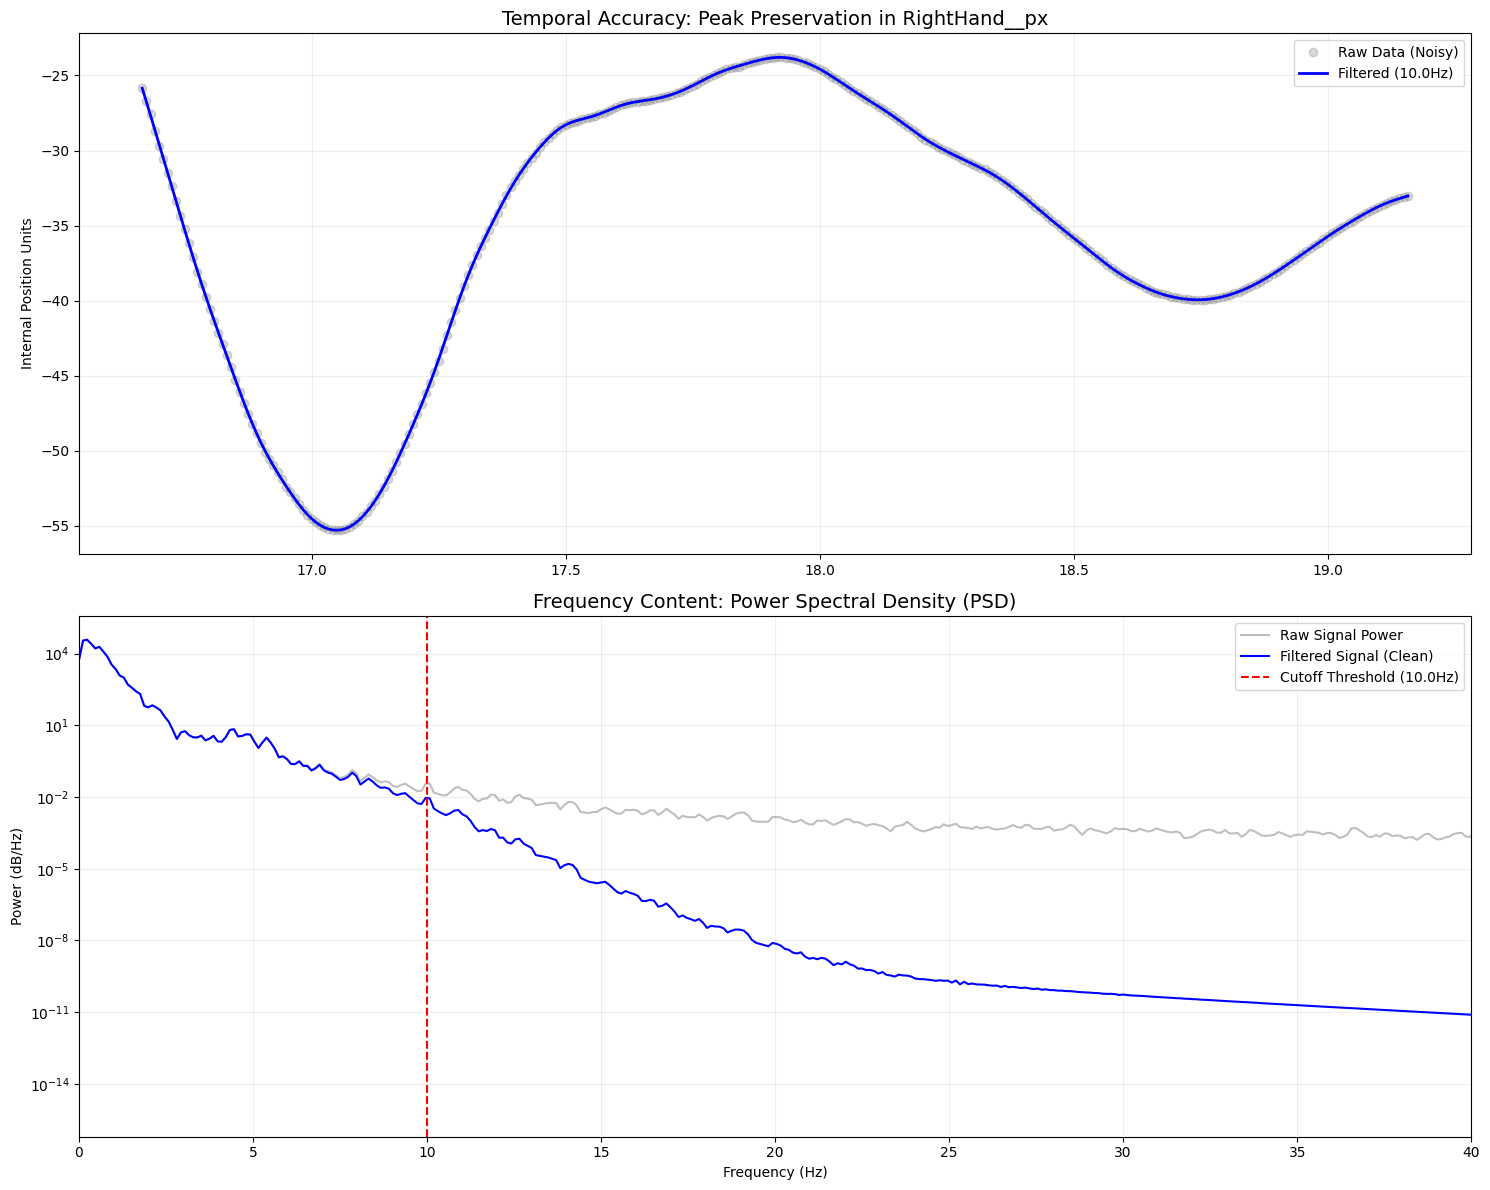

In [4]:
from scipy.signal import welch

def plot_scientific_validation(df_raw, df_filt, col, fs, cutoff):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # גרף 1: מבחן הזמן (Temporal Validation) - זום על תנועת Gaga מהירה
    start, end = 2000, 2300 # חלון של 2.5 שניות
    ax1.plot(df_raw['time_s'][start:end], df_raw[col][start:end], 'o', color='gray', alpha=0.3, label='Raw Data (Noisy)')
    ax1.plot(df_filt['time_s'][start:end], df_filt[col][start:end], color='blue', lw=2, label=f'Filtered ({cutoff}Hz)')
    ax1.set_title(f"Temporal Accuracy: Peak Preservation in {col}", fontsize=14)
    ax1.set_ylabel("Internal Position Units")
    ax1.legend()
    ax1.grid(True, alpha=0.2)

    # גרף 2: מבחן התדר (Frequency Validation) - PSD
    # זה הגרף שמוכיח למבקר המאמר שלא איבדת מידע
    f_raw, p_raw = welch(df_raw[col], fs, nperseg=1024)
    f_filt, p_filt = welch(df_filt[col], fs, nperseg=1024)
    
    ax2.semilogy(f_raw, p_raw, label='Raw Signal Power', color='gray', alpha=0.5)
    ax2.semilogy(f_filt, p_filt, label='Filtered Signal (Clean)', color='blue')
    ax2.axvline(cutoff, color='red', linestyle='--', label=f'Cutoff Threshold ({cutoff}Hz)')
    
    ax2.set_title("Frequency Content: Power Spectral Density (PSD)", fontsize=14)
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("Power (dB/Hz)")
    ax2.set_xlim([0, 40]) # רוב התנועה האנושית היא מתחת ל-20Hz
    ax2.legend()
    ax2.grid(True, which='both', alpha=0.2)

    plt.tight_layout()
    plt.show()

# הרצה על יד ימין - המקום בו יש הכי הרבה "רעש" ותנועה מהירה
plot_scientific_validation(df, df_filtered, "RightHand__px", FS, CUTOFF)

In [ ]:
# --- CELL 05: Data Persistence & Traceability ---
# RATIONALE: Saving the filtered signal in Parquet format preserves floating-point 
# precision, which is critical for the numerical differentiation (Velocity/Acceleration) 
# in the upcoming notebooks.

# --- CELL 05: Data Persistence & Traceability ---
import shutil 

# 1. Save Filtered Kinematic Data
out_path = os.path.join(DERIV_04, f"{RUN_ID}__filtered.parquet")
df_filtered.to_parquet(out_path, index=False)

# 2. Forward the Kinematics Map
map_src = os.path.join(DERIV_03, f"{RUN_ID}__kinematics_map.json")
map_dst = os.path.join(DERIV_04, f"{RUN_ID}__kinematics_map.json")

if os.path.exists(map_src):
    shutil.copy(map_src, map_dst)
    print(f"✅ METADATA: Kinematics map forwarded to Step 04.")

print(f"🎉 SUCCESS: Filtered data saved to: {out_path}")
print(f"📊 Final Shape: {df_filtered.shape}")

✅ METADATA: Kinematics map forwarded to Step 04.
🎉 SUCCESS: Filtered data saved to: /Users/drorhazan/Documents/untitled folder/Gaga-mocap-Kinematics/derivatives/step_04_filtering/734_T1_P1_R1_Take 2025-12-01 02.18.27 PM__filtered.parquet
📊 Final Shape: (30798, 149)


In [8]:
import json

def export_filter_summary(df_orig, run_id, save_dir, cutoff, order, fs, mass, height):
    """
    RATIONALE: Documentation of filter parameters and anthropometrics is 
    essential for reproducibility in biomechanical research.
    """
    total_frames = len(df_orig)
    missing_pct = float(df_orig.isna().mean().mean() * 100)
    
    summary = {
        "run_id": run_id,
        "identity": {
            "timestamp": pd.Timestamp.now().strftime('%Y-%m-%d %H:%M'),
            "pipeline_version": "v2.5_robust_gaga"
        },
        "subject_metadata": {
            "mass_kg": mass,
            "height_cm": height,
            "units_status": "internal_unscaled" # תזכורת שעוד לא המרנו למטרים
        },
        "raw_quality": {
            "total_frames": total_frames,
            "missing_data_percent": round(missing_pct, 3),
            "sampling_rate_actual": fs
        },
        "filter_params": {
            "filter_type": "Butterworth Low-pass (Zero-phase)",
            "filter_cutoff_hz": cutoff,
            "filter_order": order,
            "normalization_applied": True # אישור שנרמלנו קוואטרניונים
        }
    }
    
    out_path = os.path.join(save_dir, f"{run_id}__filtering_summary.json")
    with open(out_path, 'w') as f:
        json.dump(summary, f, indent=4)
    
    print(f"\n{'='*20} FILTER SUMMARY EXPORTED {'='*20}")
    print(f"✅ Path: {out_path}")
    print(f"📊 Quality: {missing_pct:.2f}% missing data")
    print(f"👤 Subject: {mass}kg, {height}cm")
    print(f"{'='*50}\n")

# הרצה עם כל הפרמטרים החדשים
export_filter_summary(df, RUN_ID, DERIV_04, CUTOFF, ORDER, FS, SUBJECT_MASS, SUBJECT_HEIGHT)


==================== FILTER SUMMARY EXPORTED ====================
✅ Path: /Users/drorhazan/Documents/untitled folder/Gaga-mocap-Kinematics/derivatives/step_04_filtering/734_T1_P1_R1_Take 2025-12-01 02.18.27 PM__filtering_summary.json
📊 Quality: 0.00% missing data
👤 Subject: Nonekg, Nonecm

